In [1]:
# Energy resolution

# Angular resoliution

# Effective area

In [2]:
from histpy import Axis, HealpixAxis, Axes, Histogram
from astropy.coordinates import SkyCoord
import astropy.units as u
from scoords import SpacecraftFrame
from scipy.stats.sampling import TransformedDensityRejection, SimpleRatioUniforms, NumericalInverseHermite, NumericalInversePolynomial
import matplotlib.pyplot as plt

from scipy.stats import norm, lognorm, truncnorm, vonmises
import numpy as np

from scipy.special import roots_legendre

from mhealpy import HealpixMap
from astropy.coordinates import concatenate as concatenate_skycoords

from scipy.integrate import quad, fixed_quad

from scipy.special import erf, erfi

from scipy.stats import poisson, expon, chi2

import astropy

## Inputs

In [3]:
angres = np.deg2rad(3)
energy_frac_res = .05
peak_aeff = 16**2
Ei_quad_order = 100 # Used to convolve the effective are with the spectrum. Results can be off if too low

In [4]:
Ei_axis = Axis(np.geomspace(100,10000, 10+1))
Em_axis = Axis(np.geomspace(200,5000, 10+1))
lonlat_axis = HealpixAxis(nside = 8, coordsys = SpacecraftFrame())
az_axis = Axis(np.linspace(0,2*np.pi,36+1))
phi_axis = Axis(np.linspace(0,np.pi,18+1))

r = np.concatenate((np.linspace(-np.pi, -3*angres, 10)[:-1], 
                    np.linspace(-3*angres, 3*angres, 10), 
                    np.linspace(3*angres, np.pi, 10)[1:]))
arm_axis = Axis(r)

rsp_axes = Axes([Ei_axis, lonlat_axis, Em_axis, phi_axis, az_axis, arm_axis])
data_axes = Axes([Em_axis, phi_axis, az_axis, arm_axis])

np.prod(rsp_axes.nbins)/1e9

1.3436928

## Functions

In [5]:
def prob_arm(arm, phi):
    # normalized such that int_0^pi random_arm = 1  (already includes sin(phi+arm))
    
    #Integrate[PDF[TruncatedDistribution[{0,\[Pi]},NormalDistribution [\[Phi],\[Sigma]]], x]Sin[x],{x,0,\[Pi]}]//Re//FullSimplify
    #Mathematica couldn't get only the real part analytically
    norm = np.real(
        np.exp(-(angres**2/2)-1j *phi) * 
        (1j *erf((np.pi+1j *angres**2-phi)/(np.sqrt(2) * angres))+
         np.exp(2j *phi) *(erfi((angres**2-1j *phi)/(np.sqrt(2) *angres))-
                          erfi((1j *np.pi+angres**2-1j *phi)/(np.sqrt(2) *angres)))+
         erfi((angres**2+1j *phi)/(np.sqrt(2) *angres)))
            /(2 *(erf(phi/(np.sqrt(2) *angres))-erf((-np.pi+phi)/(np.sqrt(2) *angres)))))
    
    return truncnorm.pdf(arm, -phi/angres, (np.pi-phi)/angres, 0, angres) * np.sin(phi+arm) / norm

def random_arm(phi):
    
    class Arm_dist:
        def __init__(self, phi):
            self._phi = phi

        def pdf(self, arm):
            
            return prob_arm(arm, self._phi) 
            # Not normalized
            #return truncnorm.pdf(arm, -self._phi/angres, (np.pi-self._phi)/angres, 0, angres) * np.sin(self._phi+arm)
    
    return np.array([SimpleRatioUniforms(Arm_dist(ph), mode = 0, domain = (-ph,np.pi-ph)).rvs(1)[0]
            for ph in phi])

def sr_arm_az(phi, arm1, arm2, az1, az2):
    
    arm1 = np.maximum(-phi, arm1)
    arm2 = np.minimum(np.pi-phi, arm2)
    
    return (az1-az2) * (np.cos(phi+arm1) - np.cos(phi + arm2))

def prob_az(az):
    
    return 1/(2*np.pi)

def cdf_az(az):

    return az/(2*np.pi)

def prob_armaz(phi, arm, az):
        
    # Account for solid angle area
    
    return prob_arm(arm, phi) * prob_az(az) / np.sin(phi+arm)

def prob_Em(Em, Ei):

    return norm.pdf(Em, Ei, Ei*energy_frac_res)

def cdf_Em(Em, Ei):

    return norm.cdf(Em, Ei, Ei*energy_frac_res)

def prob_phi(phi, Ei):
    # Pseudo Klein Nishina with E'=E
    # normalized such that int_0^pi random_phi = 1 (already includes sin(phi) factor)
    
    e = Ei/511
    
    return e * np.sin(phi) / (1+e*(1-np.cos(phi))) / np.log(1+2*e)

def cdf_phi(phi, Ei):
    # Pseudo Klein Nishina with E'=E, normalized
        
    e = Ei/511
    
    return np.log(1 + e*(1-np.cos(phi))) / np.log(1+2*e)

def dpdf_phi(phi, Ei):
    # Pseudo Klein Nishina with E'=E, normalized
        
    e = Ei/511
    
    return e*((1+e)*np.cos(phi) - e) / (1+e*(1-np.cos(phi)))**2 / np.log(1+2*e)

def Aeff(Ei, coord):
    
    Ei = np.array(Ei, ndmin = 1)[:,None]
    
    if coord.shape == ():
        coord = coord[None]
    
    coord = coord[None,:]
    
    lon,lat = coord.lon.rad, coord.lat.rad
    
    aeff = peak_aeff * np.cos(np.pi/2-lat)**2 * np.exp( -(np.log10(Ei) - np.log10(1000))**2  / 2 / .04 )
    
    aeff[:,lat[0,:] < 0] = 0
    
    return aeff

def get_pol_unit_vec(x,y,z):
    """
    Return (3, N)
    """
    
    px = np.array([((1+z) - (x**2-y**2)/(1+z))/2, -x*y/(1+z), -x])
    py = np.array([-x*y/(1+z), 1 - y**2/(1+z), -y])

    return px, py
    
def prob_EmCDS(Ei, coord, Em, phi, psichi):
    
    # Convert psichi to az,arm
    sep,az = psichi_to_phiaz(coord, psichi)
    arm = sep - phi[None,:]
    
    # Broadcast
    
    Ei = Ei[:, None, None]
    coord = coord[:, None, None]
    
    Em = Em[None, None,:]
    phi = phi[None, None,:]
    arm = arm[None, :, :]
    
    return prob_Em(Em, Ei) *  prob_armaz(phi, arm, az) * prob_phi(phi, Ei)
    
def dAeff(Ei, coord, Em, phi, psichi):
    
    Ei = np.array(Ei, ndmin = 1)
    
    if coord.shape == ():
        coord = coord[None]
    
    Em = np.array(Em, ndmin = 1)
    phi = np.array(phi, ndmin = 1)
    
    if psichi.shape == ():
        psichi = psichi[None]
    
    if Em.shape != phi.shape or phi.shape != psichi.shape:
        raise RuntimeError("Em, phi and psichi must have the same shape")
    
    # Tot aeff
    aeff = Aeff(Ei, coord)
    
    return aeff[:,:,None] * prob_EmCDS(Ei, coord, Em, phi, psichi)

In [6]:
def random_phi(Ei):
    
    class Phi_dist:
        def __init__(self, Ei):
            self._Ei = Ei

        def pdf(self, phi):
            return prob_phi(phi, self._Ei)
    
        def cdf(self, phi):
            return cdf_phi(phi, self._Ei)
        
#         def dpdf(self, phi):
            
#             return dpdf_phi(phi, self._Ei)
            
    # Distribution seems off (why?)
    return np.array([SimpleRatioUniforms(Phi_dist(e),
                                         mode = np.arctan(np.sqrt(1+2*(e/511))/(e/511)),
                                         domain = (0,np.pi)).rvs(1)[0]
                     for e in Ei])

    # Errors
    # return np.array([TransformedDensityRejection(Phi_dist(e), mode = np.arctan(np.sqrt(1+2*e)/e), domain = (0,np.pi)).rvs(1)[0]
    #         for e in Ei/511])
    
    # Also off. And slow.
    # return np.array([NumericalInverseHermite(Phi_dist(e), domain = (0,np.pi)).rvs(1)[0]
    #         for e in Ei/511])

    # Too slow, didn't check
#     return np.array([NumericalInversePolynomial(Phi_dist(e), mode = np.arctan(np.sqrt(1+2*e)/e), domain = (0,np.pi)).rvs(1)[0]
#             for e in Ei/511])
    
def phiaz_to_psichi(skycoord, phi, az):
    
    # Transform phi,az to psi,chi
    x,y,z = skycoord.cartesian.xyz
    
    # Reference vector for polarization
    px,py = get_pol_unit_vec(x,y,z)
    
    px = px.transpose()
    py = py.transpose()    
        
    psichi_xyz = (np.sin(phi[:,None]) * (px * np.cos(az[:,None]) + 
                                         py * np.sin(az[:,None])) + 
                  skycoord.cartesian.xyz * np.cos(phi[:,None]))
    
    psichi = SkyCoord(psichi_xyz,
                      representation_type = 'cartesian',
                      frame = SpacecraftFrame())
    psichi.representation_type = 'unitspherical'
    
    return psichi

def psichi_to_phiaz(coord, psichi):
    
    psichi_pvec = psichi.cartesian.xyz[:,None,:] - coord.cartesian.xyz[:,:,None]
    
    px,py = get_pol_unit_vec(*coord.cartesian.xyz)
    
    px = px[:,:,None]
    py = py[:,:,None]
    
    #psichi_px = np.tensordot(px, psichi_pvec, axes = ([0],[0]))
    #psichi_py = np.tensordot(py, psichi_pvec, axes = ([0],[0]))
    # There should be a better way to do the dotprod along axis=0. I'll figure it out someday
    psichi_px = np.sum(px*psichi_pvec, axis = 0)
    psichi_py = np.sum(py*psichi_pvec, axis = 0)
    
    az = np.arctan2(psichi_py, psichi_px)
    
    phi = coord[:,None].separation(psichi[None,:]).rad
    
    return phi,az
    
def random_psichi(phi, skycoord):
    
    az = np.random.uniform(0, 2*np.pi, size = phi.size)
    arm = random_arm(phi)
    
    # Transform arm,az to psi,chi
    psichi = phiaz_to_psichi(skycoord, phi + arm, az)
    
    return psichi
    
    
def random_event(Ei, skycoord):
    
    Em = np.random.normal(Ei, Ei*energy_frac_res)

    phi = random_phi(Ei)

    psichi = random_psichi(phi, skycoord)
    
    return Em, phi, psichi



In [7]:
powerlaw = lambda e,n,index: n*(e/1000)**-index

def get_diff_bkg_expectation(Em, phi, psichi):
    
    return ((expon.pdf(Em, loc = 200, scale = 500)) *  # Exponential in energy
            (np.sin(phi)/2) *                           # Flat in phi
            (1 / 4 / np.pi))                            # Isotropic in psichi

def random_bkg_event(nevents):
    
    # Isotropic in psichi
    psichi = SkyCoord(np.random.uniform(-1, 1, size = (nevents, 3)), 
                      representation_type = 'cartesian', frame = SpacecraftFrame())
    psichi.representation_type = 'spherical'

    # Exponential in energy
    Em = expon(loc = 200, scale = 500).rvs(nevents)
    
    # Flat in phi
    dir_out = SkyCoord(np.random.uniform(-1, 1, size = (nevents, 3)), 
                          representation_type = 'cartesian')
    dir_out.representation_type = 'physicsspherical'
    phi = dir_out.theta.rad
    
    return Em, phi, psichi

In [8]:
def roots_legendre_lims(n, a, b):
    
    x,w = roots_legendre(n)
    
    x = (b - a)/2 * x + (a + b)/2
    
    return x, w

def get_tot_ex_counts(spectrum, skycoord):

    #return quad(lambda Ei: Aeff(Ei, skycoord)*spectrum(Ei), Ei_axis.lo_lim, Ei_axis.hi_lim)[0]

    emin = Ei_axis.lo_lim
    emax = Ei_axis.hi_lim
    
    Ei, weights = roots_legendre_lims(Ei_quad_order, emin, emax)

    return (emax - emin)/2 * np.sum(Aeff(Ei, sloc)*spectrum(Ei)[:,None]*weights[:,None], axis = 0)
    
def get_diff_expectation(spectrum, skycoord, Em, phi, psichi):
    
    # Integrate over Ei using GL quadrature
    Ei, weights = roots_legendre_lims(Ei_quad_order, Ei_axis.lo_lim, Ei_axis.hi_lim)
    
    daeff = dAeff(Ei, skycoord, Em, phi, psichi)
    dexpect = ((Ei_axis.hi_lim - Ei_axis.lo_lim)/2 * 
               np.sum(daeff*spectrum(Ei)[:,None,None]*weights[:,None,None], axis = 0))
    
    return dexpect
    
def log_like_events(spectrum, skycoord, nbkg, Em, phi, psichi):

    if nbkg != 0:
        dexpect_b = nbkg*get_diff_bkg_expectation(Em, phi, psichi)[None,:]
    else:
        dexpect_b = np.zeros((1,)+Em.shape)

    if spectrum is not None:
        dexpect_s = get_diff_expectation(spectrum, skycoord, Em, phi, psichi)
    else:
        dexpect_s = np.zeros((1,)+Em.shape)
    
    dexpect = dexpect_b + dexpect_s
    
    #Supress log(0) warning
    dexpect = np.maximum(dexpect, np.finfo(float).resolution)
    
    like_events = np.sum(np.log(dexpect), axis = 1)
    
    return like_events

def log_like(spectrum, skycoord, nbkg, Em, phi, psichi):
    
    # Total expected signal events
    tot_excess = get_tot_ex_counts(spectrum, skycoord)
    
    # Event by event
    like_events = log_like_events(spectrum, skycoord, nbkg, Em, phi, psichi)
    like_events_null = log_like_events(None, None, nbkg, Em, phi, psichi)
    
    like = (like_events - like_events_null) - tot_excess # tot nbkg counts cancel out
    
    return like

In [9]:
class FunStat:
    
    def __init__(self, fun, xmin, xmax):
        
        self._norm = quad(fun, xmin, xmax)[0]
        self._xmin = xmin
        self._xmax = xmax
        self._fun = fun

    @property
    def norm(self):
        return self._norm
        
    def cdf(self, x):
        
        return quad(self._fun, self._xmin, x)[0]/self._norm
        
    def pdf(self, x):
        
        return self._fun(x)/self._norm
    
    def rvs(self, size = 1):
        
        return SimpleRatioUniforms(self, domain = (self._xmin,self._xmax)).rvs(size)
    
def random_Ei(spectrum, skycoord, size = 1):
    
    return FunStat(lambda e: Aeff(e, skycoord) * spectrum(e), Ei_axis.lo_lim, Ei_axis.hi_lim).rvs(size)

### Tests functions

In [10]:
quad(lambda Em: prob_Em(Em, 500), 200, 5000)

(1.0000000000000002, 9.103624532850387e-13)

In [11]:
phi = np.deg2rad(.1)
quad(lambda arm: prob_arm(arm, phi), -phi, np.pi-phi)

(0.9999999999999999, 7.833343063628786e-13)

In [12]:
quad(lambda az: prob_az(az), 0, 2*np.pi)

(1.0, 1.1102230246251565e-14)

In [13]:
quad(lambda phi: prob_phi(phi, 1000), 0, np.pi)

(1.0, 4.756307875823963e-13)

In [14]:
phi = np.deg2rad(10)

sloc = SkyCoord(lon = [0]*u.deg, lat = [90]*u.deg, frame = SpacecraftFrame())

psichi_axis = HealpixAxis(nside = 128, coordsys = SpacecraftFrame())

pix_centers = psichi_axis.pix2skycoord(np.arange(psichi_axis.npix))

sep,az = psichi_to_phiaz(sloc, pix_centers)

arm = phi - sep

np.sum( prob_armaz(phi, arm, az) * psichi_axis.pixarea(np.arange(psichi_axis.npix)).to_value(u.sr))

0.9999999999999984

In [15]:
Em_axis = Axis(np.geomspace(200, 5000, 40))
phi_axis = Axis(np.linspace(0,np.pi, 36+1))
psichi_axis = HealpixAxis(nside = 32, coordsys = SpacecraftFrame())


pix_centers = psichi_axis.pix2skycoord(np.arange(psichi_axis.npix))

Em_m, phi_m, lon_m = np.meshgrid(Em_axis.centers, 
                                 phi_axis.centers, 
                                 pix_centers.lon.rad)

Em_m, phi_m, lat_m = np.meshgrid(Em_axis.centers, 
                                 phi_axis.centers, 
                                 pix_centers.lat.rad)

psichi_m = SkyCoord(lon = lon_m*u.rad, lat = lat_m*u.rad, frame = SpacecraftFrame())


Em_del, phi_del, psichi_del = np.meshgrid(Em_axis.widths, 
                                          phi_axis.widths, 
                                          psichi_axis.pixarea(np.arange(psichi_axis.npix)).to_value(u.sr))


Ei = 500
sloc = SkyCoord(lon = 10*u.deg, lat = 80*u.deg, frame = SpacecraftFrame())

print(np.sum(np.reshape(dAeff(Ei, sloc, 
                              Em_m.flatten(), 
                              phi_m.flatten(), 
                              psichi_m.flatten()), Em_m.shape) * 
             Em_del * 
             phi_del * 
             psichi_del))

print(Aeff(Ei, sloc))

79.99298273019933
[[79.98359514]]


In [16]:
sloc = SkyCoord(lon = 10*u.deg, lat = 45*u.deg, frame = SpacecraftFrame())

powerlaw = lambda e,n,index: n*(e/500)**-index

pl_norm = 1
pl_index = 2
spectrum = lambda e: powerlaw(e, pl_norm, pl_index)

emin = Ei_axis.lo_lim
emax = Ei_axis.hi_lim

# Trapz
eint = np.geomspace(emin,emax,10000)
print(np.sum(Aeff(eint[:-1], sloc)*spectrum(eint[:-1])[:,None]*np.diff(eint)[:,None], axis = 0))

# Quad
print(get_tot_ex_counts(spectrum, sloc))
print(quad(lambda Ei: Aeff(Ei, sloc)*spectrum(Ei), emin, emax))
print(fixed_quad(lambda Ei: Aeff(Ei, sloc)[:,0]*spectrum(Ei), emin, emax, n = 20)[0])

# Manual quad
Ei, weights = roots_legendre_lims(20, emin, emax)
    
(emax - emin)/2 * np.sum(Aeff(Ei, sloc)*spectrum(Ei)[:,None]*weights[:,None], axis = 0)

[41080.53402702]
[41071.07439298]
(41071.07439298276, 3.963841975179738e-06)
41072.256887564276


array([41072.25688756])

/var/folders/3_/k9d8ljjn5hv2xks5822zlyrm26_jpd/T/ipykernel_82982/3372232424.py:24: RuntimeWarning: [objid: SROU] 22 : mode: try finding it (numerically) => (distribution) incomplete distribution object, entry missing
  return SimpleRatioUniforms(self, domain = (self._xmin,self._xmax)).rvs(size)
/Users/imartin5/burstcube/software/histpy/histpy/histogram.py:1301: RuntimeWarning: invalid value encountered in divide
  self._contents = operation(self.full_contents, other)


(0.001, 100.0)

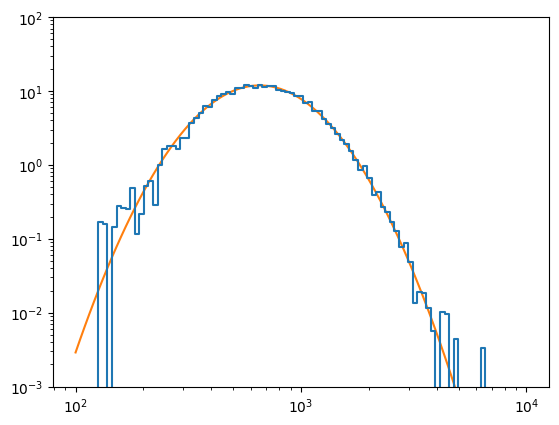

In [17]:
h = Histogram(np.geomspace(emin, emax, 100))

powerlaw = lambda e,n,index: n*(e/1000)**-index
spectrum = lambda e: powerlaw(e, 1e-4, 2)

skycoord = SkyCoord(lon = 10*u.deg, lat = 45*u.deg, frame = SpacecraftFrame())

n = 10000
h.fill(random_Ei(spectrum, skycoord, n))

h /= h.axis.widths

ax, plot = h.plot()

eplot = np.geomspace(emin,emax,100)
ax.plot(eplot[:-1], n * Aeff(eplot[:-1], skycoord)[:,0] * spectrum(eplot[:-1]) / 
                        quad(lambda e: Aeff(e, skycoord)[:,0] * spectrum(e), emin, emax)[0])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylim(1e-3, 1e2)

In [186]:
16*2

32

Text(0, 0.5, 'Aeff [cm2]')

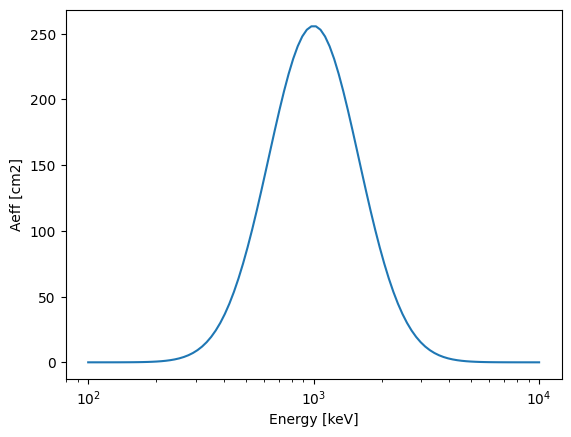

In [192]:
fig,ax = plt.subplots()

skycoord = SkyCoord(lon = 0*u.deg, lat = 90*u.deg, frame = SpacecraftFrame())

eplot = np.geomspace(100,10000,100)
ax.plot(eplot, Aeff(eplot, skycoord)[:,0])

ax.set_xscale('log')
#ax.set_yscale('log')

ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Aeff [cm2]")

Text(0, 0.5, 'Aeff [cm2]')

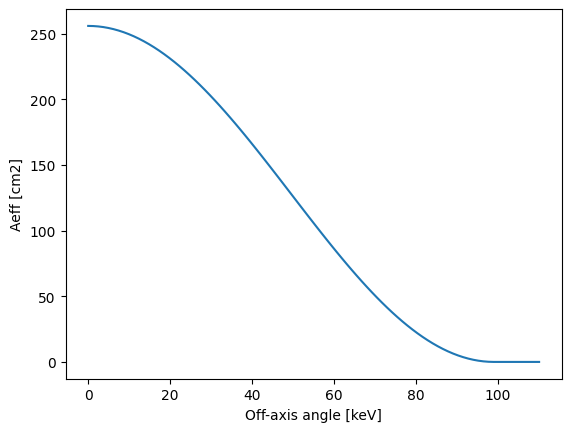

In [202]:
fig,ax = plt.subplots()

skycoord = SkyCoord(lon = np.zeros(90)*u.deg, lat = np.linspace(90,-10,90)*u.deg, frame = SpacecraftFrame())

ax.plot(np.linspace(0,110,90)*u.deg, Aeff([1000], skycoord)[0,:])

ax.set_xlabel("Off-axis angle [keV]")
ax.set_ylabel("Aeff [cm2]")

/var/folders/3_/k9d8ljjn5hv2xks5822zlyrm26_jpd/T/ipykernel_82982/3372232424.py:24: RuntimeWarning: [objid: SROU] 22 : mode: try finding it (numerically) => (distribution) incomplete distribution object, entry missing
  return SimpleRatioUniforms(self, domain = (self._xmin,self._xmax)).rvs(size)


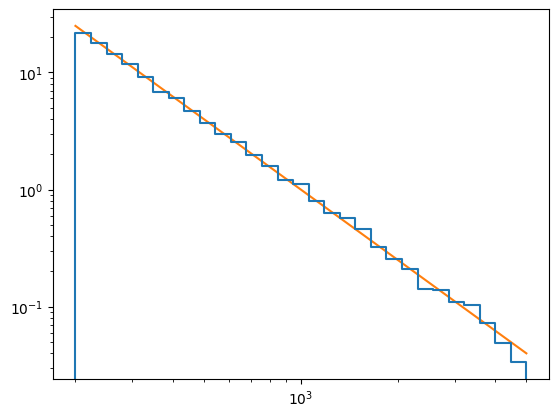

In [18]:
h = Histogram(np.geomspace(200,5000, 30))

emin = 200
emax = 5000

powerlaw = lambda e,n,index: n*(e/1000)**-index
spectrum = lambda e: powerlaw(e, 1e-4, 2)

spectrum_stat = FunStat(spectrum, emin, emax)

n = 10000
h.fill(spectrum_stat.rvs(n))

h *= spectrum_stat.norm/h.axis.widths

ax, plot = h.plot()

eplot = np.geomspace(emin,emax,100)
ax.plot(eplot, n*spectrum(eplot))

ax.set_xscale('log')
ax.set_yscale('log')

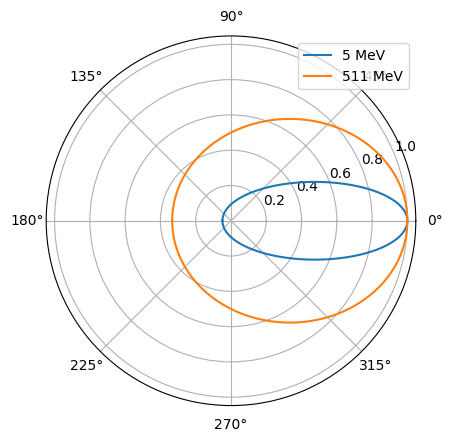

In [230]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
phi = np.linspace(-np.pi,np.pi, 1000)
ax.plot(phi, 1/(1+(5000/511)*(1-np.cos(phi))), label = "5 MeV" )
ax.plot(phi, 1/(1+(511/511)*(1-np.cos(phi))), label = "511 MeV" )

ax.legend()

/var/folders/3_/k9d8ljjn5hv2xks5822zlyrm26_jpd/T/ipykernel_82982/748240152.py:3: RuntimeWarning: invalid value encountered in divide
  ax.plot(phi, prob_phi(phi, 500)/np.sin(phi))


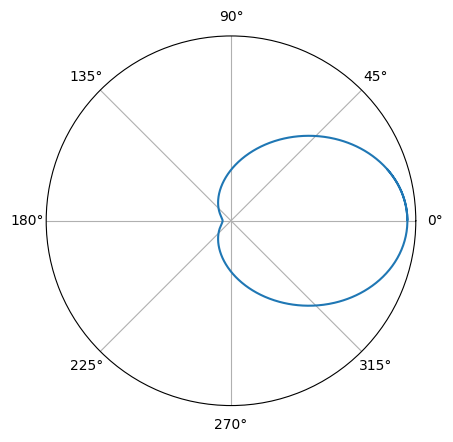

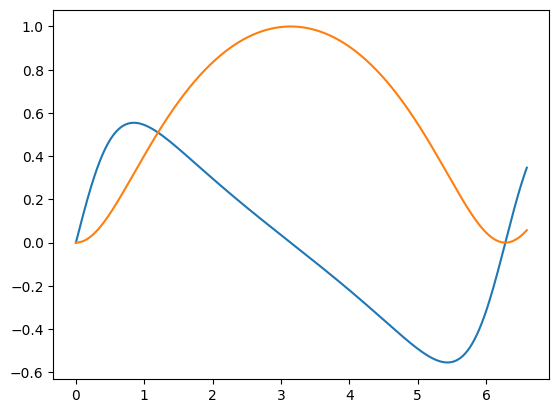

In [209]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
phi = np.linspace(0,2.1*np.pi, 1000)
ax.plot(phi, prob_phi(phi, 500)/np.sin(phi))

ax.yaxis.set_ticks([])

fig, ax = plt.subplots()
ax.plot(phi, prob_phi(phi, 1000))
ax.plot(phi, cdf_phi(phi, 1000))

In [20]:
nevents = 1000
Ei = 500
Em, phi, psichi = random_event(np.broadcast_to(Ei, nevents), 
                               SkyCoord(lon = 0*u.deg, lat = 90*u.deg, frame = SpacecraftFrame()))

Failed to transform from 'spacecraftframe' to 'icrs'. Rasterizing in 'spacecraftframe' frame. ERROR: Spacecraft coordinates need attitude to transform to inertial frame


(0.0, 1000.0)

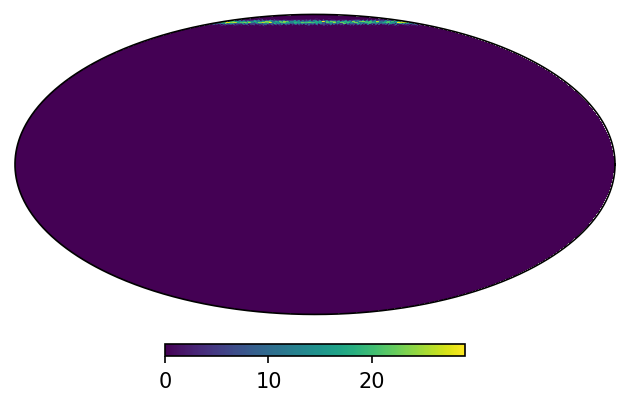

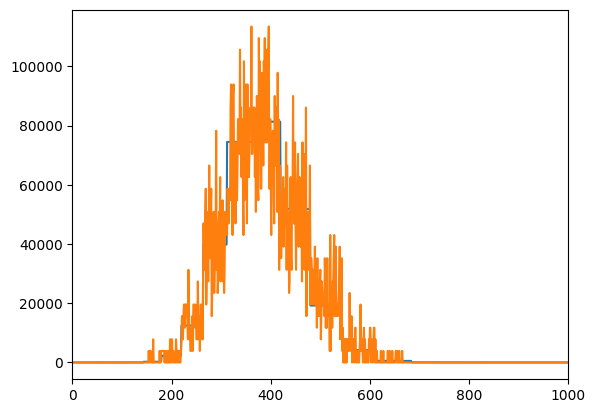

In [21]:
phi = np.deg2rad(10)

nevents = 4000

skycoord = SkyCoord(lon = 0*u.deg, 
                    lat = 90*u.deg, 
                    frame = SpacecraftFrame())

psichi = random_psichi(phi * np.ones(nevents), skycoord)

m = Histogram(HealpixAxis(nside = 64, coordsys = SpacecraftFrame()))
m.fill(psichi)

m.plot()


sep,az = psichi_to_phiaz(skycoord[None], m.axis.pix2skycoord(np.arange(m.axis.npix)))
arm = phi - sep

fig,ax = plt.subplots()

#print(prob_armaz(phi, arm, az).shape)
ax.plot(nevents*prob_armaz(phi, arm, az)[0]);
ax.plot(m[:]/m.axis.pixarea())

ax.set_xlim(0,1000)

In [22]:
bdata = Histogram([Axis(np.geomspace(200,5000,100), 'Em'), 
                   Axis(np.linspace(0,2*np.pi,180), 'phi'), 
                   HealpixAxis(nside = 64, coordsys = SpacecraftFrame(), label = 'psichi')])
bdata.fill(Em, phi, psichi)
bdata.slice[{'phi':1}].project('psichi').plot()

bdata.project('Em').plot()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1000,) and arg 2 with shape (4000,).

In [23]:
quad(lambda phi: prob_phi(phi, 500), 0, np.pi/4)

(0.23243301629446822, 2.580524863731928e-15)

In [24]:
cdf_phi(np.pi/4, 500)

0.2324330162944681

In [ ]:
nevents = 4000


#Single energy
Ei = 500
h = Histogram(phi_axis)
h.fill(random_phi(np.broadcast_to(Ei, nevents)))
h /= h.axis.widths
ax,plot = h.plot()
ax.plot(phi_axis.centers, nevents*prob_phi(phi_axis.centers, Ei))

e = Ei/511
ax.axvline(np.arctan(np.sqrt(1+2*e)/e))

#Multiple
h = Histogram(phi_axis)
Ei = np.geomspace(100,5000,nevents)

h.fill(random_phi(Ei))
h /= h.axis.widths

wprob = np.zeros(phi_axis.nbins)
for e in Ei:
    wprob += prob_phi(phi_axis.centers, e)
        
ax,plot = h.plot()
ax.plot(phi_axis.centers, wprob)


AttributeError: 'YAxis' object has no attribute 'set_tickslabels'

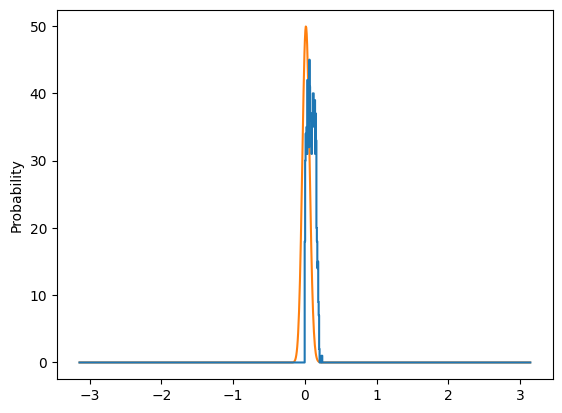

In [235]:
fig, ax = plt.subplots()

plot_axis = Axis(np.linspace(-np.pi, np.pi, 1000))

h = Histogram(plot_axis)
h.fill(random_arm(np.ones(1000)*np.deg2rad(.1)))
h.plot(ax)

ax.plot(plot_axis.centers, 1000*prob_arm(plot_axis.centers, np.deg2rad(10))*plot_axis.widths)

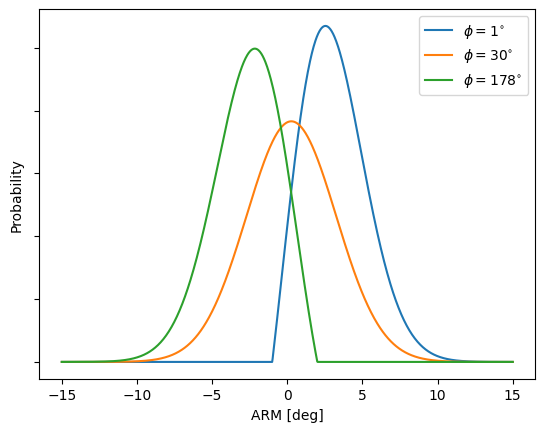

In [264]:
fig, ax = plt.subplots()

armplot = np.linspace(-5*angres, 5*angres, 1000)

ax.plot(np.rad2deg(armplot), prob_arm(armplot, np.deg2rad(1)), label = "$\phi = 1^{\circ}$")
ax.plot(np.rad2deg(armplot), prob_arm(armplot, np.deg2rad(30)), label = "$\phi = 30^{\circ}$")
ax.plot(np.rad2deg(armplot), prob_arm(armplot, np.deg2rad(178)), label = "$\phi = 178^{\circ}$")

ax.set_ylabel('Probability')
ax.set_xlabel('ARM [deg]')
ax.yaxis.set_ticklabels([])

ax.legend()

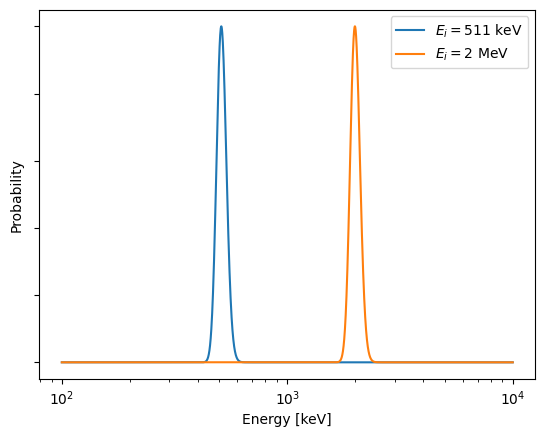

In [263]:
fig, ax = plt.subplots()

eplot = np.linspace(100, 10000, 10000)

ax.plot(eplot, prob_Em(511, eplot)/np.max(prob_Em(511, eplot)), label = "$E_i = 511$ keV")

ax.plot(eplot, prob_Em(2000, eplot)/np.max(prob_Em(2000, eplot)), label = "$E_i = 2$ MeV")

ax.legend()

ax.set_ylabel('Probability')
ax.set_xlabel('Energy [keV]')
ax.yaxis.set_ticklabels([])

ax.set_xscale('log')

In [ ]:
sloc = SkyCoord(lon = 10*u.deg, lat = 45*u.deg, frame = SpacecraftFrame())

powerlaw = lambda e,n,index: n*(e/1000)**-index

spectrum = lambda e: powerlaw(e, pl_norm, pl_index)

pl_norm = 1e-2
pl_index = 1
tot_ex_counts = get_tot_ex_counts(spectrum, sloc)
nevents = poisson.rvs(tot_ex_counts)
Ei = random_Ei(spectrum, sloc, nevents)
h = Histogram(np.geomspace(200,5000))
h.fill(Ei)
ax,_ = h.plot()


pl_norm = 1e-2
pl_index = 2
tot_ex_counts = get_tot_ex_counts(spectrum, sloc)
nevents = poisson.rvs(tot_ex_counts)
Ei = random_Ei(spectrum, sloc, nevents)
h = Histogram(np.geomspace(200,5000))
h.fill(Ei)
h.plot(ax)

pl_norm = 1e-2
pl_index = 3
tot_ex_counts = get_tot_ex_counts(spectrum, sloc)
nevents = poisson.rvs(tot_ex_counts)
Ei = random_Ei(spectrum, sloc, nevents)
h = Histogram(np.geomspace(200,5000))
h.fill(Ei)
h.plot(ax)

# ax.set_yscale('log')
# ax.set_xscale('log')

## Spectrum

In [48]:
sloc = SkyCoord(lon = 0*u.deg, lat = 90*u.deg, frame = SpacecraftFrame())

powerlaw = lambda e,n,index: n*(e/1000)**-index

pl_norm = 1e-3
pl_index = 2
spectrum = lambda e: powerlaw(e, pl_norm, pl_index)

nevents_bkg = 2000

tot_ex_counts = get_tot_ex_counts(spectrum, sloc)

#nevents = int(tot_ex_counts)
nevents = poisson.rvs(tot_ex_counts)
print(nevents)

Ei = random_Ei(spectrum, sloc, nevents)
Em_s, phi_s, psichi_s = random_event(Ei, sloc)

Em_b, phi_b, psichi_b = random_bkg_event(nevents_bkg)

Em = np.append(Em_s, Em_b)
phi = np.append(phi_s, phi_b)
psichi = astropy.coordinates.concatenate([psichi_s, psichi_b])


# Ei = random_Ei(spectrum, sloc, nevents)
# Em, phi, psichi = random_event(Ei, sloc)

norm_axis = Axis(np.geomspace(pl_norm*.5, pl_norm*2, 41))
index_axis = Axis(np.linspace(pl_index-1, pl_index+1, 40))

tot_ex =  np.zeros([index_axis.nbins, norm_axis.nbins])
like_events = np.zeros([index_axis.nbins, norm_axis.nbins])
#ts = np.zeros([index_axis.nbins, norm_axis.nbins])

for norm_n,norm_i in enumerate(norm_axis.centers):
    for index_n, index_i in enumerate(index_axis.centers):
        
        spectrum_n = lambda e: powerlaw(e, norm_i, index_i)

        tot_ex[index_n, norm_n] = get_tot_ex_counts(spectrum_n, sloc)
        like_events[index_n, norm_n] = log_like_events(spectrum_n, sloc, nevents_bkg,
                                                       Em, phi, psichi)
        
ts = Histogram([index_axis, norm_axis], contents = 2*(like_events - tot_ex))

index_opt_bin,norm_opt_bin = np.unravel_index(np.argmax(ts), ts.nbins)

norm_opt = norm_axis.centers[norm_opt_bin]
index_opt = index_axis.centers[index_opt_bin]

335


/var/folders/3_/k9d8ljjn5hv2xks5822zlyrm26_jpd/T/ipykernel_70751/3372232424.py:24: RuntimeWarning: [objid: SROU] 22 : mode: try finding it (numerically) => (distribution) incomplete distribution object, entry missing
  return SimpleRatioUniforms(self, domain = (self._xmin,self._xmax)).rvs(size)


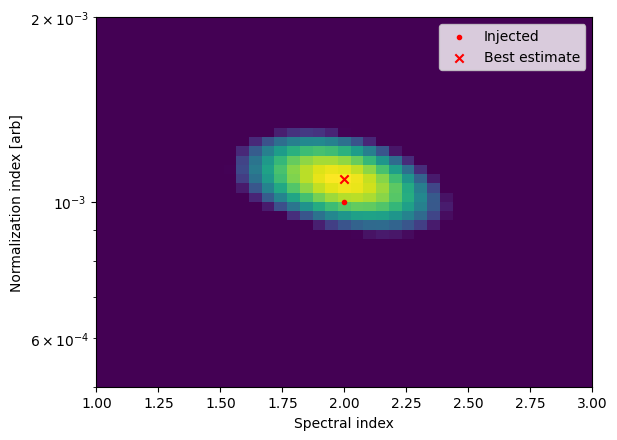

In [49]:
fig,ax = plt.subplots()
(ts-np.max(ts)).plot(ax, vmin = - chi2.isf(.01, 2), colorbar = False)
ax.scatter(pl_index, pl_norm, marker = '.', color = 'r', label = 'Injected')
ax.scatter(index_opt, norm_opt, marker = 'x', color = 'r', label = 'Best estimate')

ax.set_xlabel("Spectral index")
ax.set_ylabel("Normalization index [arb]")

ax.set_yscale('log')

ax.legend()

## Localization

In [35]:
spectrum = lambda e: 1e-4*(e/1000)**-0.1
sloc = SkyCoord(lon = 10*u.deg, lat = 45*u.deg, frame = SpacecraftFrame())

m = HealpixMap(nside = 64, coordsys = SpacecraftFrame())
skycoord = m.pix2skycoord(np.arange(m.npix))

nevents = 100
Ei = random_Ei(spectrum, sloc, nevents)
Em_s, phi_s, psichi_s = random_event(Ei, sloc)

nevents_bkg = 1000
Em_b, phi_b, psichi_b = random_bkg_event(nevents_bkg)

Em = np.append(Em_s, Em_b)
phi = np.append(phi_s, phi_b)
psichi = astropy.coordinates.concatenate([psichi_s, psichi_b])

/var/folders/3_/k9d8ljjn5hv2xks5822zlyrm26_jpd/T/ipykernel_70751/3372232424.py:24: RuntimeWarning: [objid: SROU] 22 : mode: try finding it (numerically) => (distribution) incomplete distribution object, entry missing
  return SimpleRatioUniforms(self, domain = (self._xmin,self._xmax)).rvs(size)


In [11]:
%%time
m[:] = 2*log_like(spectrum, skycoord, nevents_bkg,
                  Em, phi, psichi)

CPU times: user 8.67 s, sys: 7.21 s, total: 15.9 s
Wall time: 16.2 s


In [36]:
%%time
skycoord = m.pix2skycoord(np.arange(m.npix))

nbunch = 100

for i in range(0, m.npix, nbunch):
    
    m[i:i+nbunch] = 2*log_like(spectrum, skycoord[i:i+nbunch], nevents_bkg,
                      Em, phi, psichi)

CPU times: user 58.2 s, sys: 16.5 s, total: 1min 14s
Wall time: 1min 15s


Failed to transform from 'spacecraftframe' to 'icrs'. Rasterizing in 'spacecraftframe' frame. ERROR: Spacecraft coordinates need attitude to transform to inertial frame


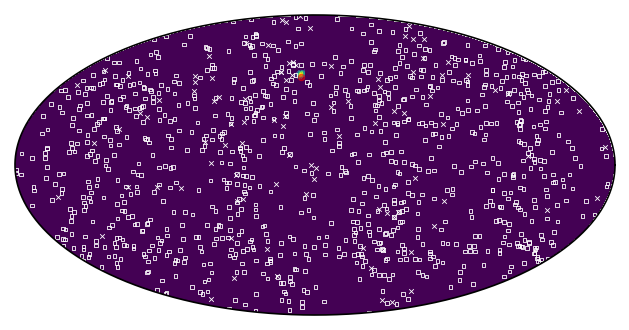

In [38]:
plot,ax = m.plot(vmin = np.max(m) - chi2.isf(.01, 2), cbar = False)
ax.get_figure().dpi = 150
ax.scatter(sloc.lon.deg, sloc.lat.deg, transform = ax.get_transform('world'), s = 10, color = 'red', alpha = .5, linewidths=.4)

ax.scatter(psichi_s.lon.deg, psichi_s.lat.deg, transform = ax.get_transform('world'), s = 5, color = 'white', marker = 'x', linewidths=.4)

# for ecoord, phi_i in zip(psichi_s,phi_s):
#     az_plot = np.linspace(0,2*np.pi, 100)
#     circle = phiaz_to_psichi(ecoord, np.array([phi_i]), az_plot)
    
#     ax.plot(circle.lon.deg, circle.lat.deg, transform = ax.get_transform('world'), linewidth = 1, color = 'white', ls = ':', alpha = 1)

ax.scatter(psichi_b.lon.deg, psichi_b.lat.deg, transform = ax.get_transform('world'), s = 3, color = 'white', marker = 's', facecolor='none', linewidths=.4)

# for ecoord, phi_i in zip(psichi_b,phi_b):
#     az_plot = np.linspace(0,2*np.pi, 100)
#     circle = phiaz_to_psichi(ecoord, np.array([phi_i]), az_plot)
    
#     ax.plot(circle.lon.deg, circle.lat.deg, transform = ax.get_transform('world'), linewidth = 1, color = 'blue', ls = ':', alpha = 0.5)

    


## Binned detector response

In [ ]:
(200-10000)/10000

## Profile

In [ ]:
import cProfile


In [ ]:
cProfile.run('log_like(spectrum, skycoord,Em, phi, psichi)', filename = "prof.prof")

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f log_like -f dAeff -f psichi_to_phiaz log_like(spectrum, skycoord,Em, phi, psichi)

In [ ]:
np.rad2deg(phi)

In [ ]:
np.sum((ecoord.cartesian.xyz)**2)

In [ ]:
circle = phiaz_to_psichi(ecoord, np.array([phi[0]]), az_plot)
    
print(ecoord.separation(circle).deg)

In [ ]:
, sinp.finfo(float).min

In [ ]:
Aeff(500, SkyCoord(lon = [10,50]*u.deg, lat = [90,45]*u.deg, frame = SpacecraftFrame()),
    np.array([501, 499, 505, 503,   500]),
      np.deg2rad([5,10,5,10,   10]),
      SkyCoord(lon = [50,50,55,60,   10]*u.deg, lat = [50, 55, 45, 45, 80]*u.deg, frame = SpacecraftFrame()))

In [ ]:
from scipy.integrate import quad

In [ ]:
spectrum = lambda e: 1e-4*(e/1000)**-2
quad(lambda e: Aeff(e, SkyCoord(lon = 10*u.deg, lat = 90*u.deg, frame = SpacecraftFrame()))*spectrum(e), 200, 5000)[0]

In [ ]:
a = np.asarray(5)
a[a>4] = 0

In [ ]:
np.empty(())